In [1]:
#neural net
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.optim as optim
import torch.nn.functional as F
from CNN_small_architecture import CNNSmall
import os
import inspect

In [2]:
def tokenize(num):
    if num == 1:
        return torch.tensor(np.array([1., 0.]))
    else:
        return torch.tensor(np.array([0., 1.]))

MNIST_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

train_set = [[data[0], tokenize(data[1])] for data in MNIST_train if data[1] in [1,2]]


batch_size = 10
train_loader = DataLoader(train_set, batch_size=batch_size)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(image_batch, one_channel=False):
    if one_channel:
        image_batch = image_batch.mean(dim=0)
    image_batch = image_batch / 2 + 0.5     # unnormalize
    npimg = image_batch.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

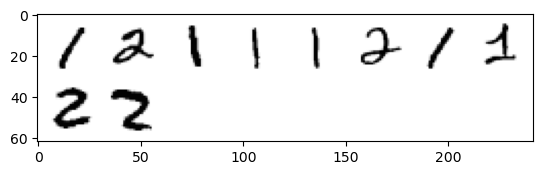

In [4]:
dataiter = iter(train_loader)

images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=True)

In [5]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
device = torch.device("cpu")
print("device:", device)

device: cpu


In [6]:
def train(model, data_loader):

    model.to(device)
    
    loss_list = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, eps=0.1)

    no_epochs = 10
    for epoch in range(no_epochs):
        epoch_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            if (gpu):
                inputs, labels = data[0].to(device), data[1].to(device)
            else:
                inputs, labels = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()

        loss_list.append(epoch_loss/(i+1.))

    return loss_list

If the model exist and we dont want to retrain ie. load is true, we load the model

In [7]:
model = CNNSmall()

path = "CNN_small"
load = True

if load and os.path.isfile(path):
    model.load_state_dict(torch.load(path))


If the model was not loaded we save it

In [8]:
if not load:
    epoch_loss = train(model, train_loader)
    torch.save(model.state_dict(), path)